In [1]:
# --- Setup (edit BASE only if your path is different) ---
from pathlib import Path
import json
import pandas as pd
import numpy as np

BASE = Path("/home/phanim/harshitrawat/summer")
MD   = BASE / "md"

# CHGNet baselines
CHG_T1 = BASE / "T1_T2_T3_data/mdinfo_chgnet_predictions_forces.json"
CHG_T2 = BASE / "T1_T2_T3_data/strain_perturb_chgnet_predictions_forces.json"
CHG_T3 = BASE / "T1_T2_T3_data/strain_perturb_primechgnet_predictions_forces.json"

OUT_COUNTS = MD / "MACE_counts_check.json"
OUT_COMBINED_XLSX = MD / "MACE_ensemble_mean_energies.xlsx"
OUT_COMBINED_JSON = MD / "MACE_ensemble_mean_energies.json"
OUT_COMPARE_XLSX = MD / "MACE_vs_CHGNet_energy_compare.xlsx"
OUT_COMPARE_JSON = MD / "MACE_vs_CHGNet_energy_compare.json"

def _norm_file_col(df):
    """Keep only columns we need and normalize file names."""
    # Try common column names
    cols = df.columns.str.lower().tolist()
    # 'file' must exist; sometimes there is 'dataset'/'subfolder' we keep for reference only
    assert "file" in cols, f"Couldn't find a 'file' column in: {df.columns.tolist()}"
    # Energy might appear as 'energy_eV' or 'energy_ev'
    energy_col = "energy_eV" if "energy_eV" in df.columns else ("energy_ev" if "energy_ev" in df.columns else None)
    assert energy_col is not None, f"No energy column found in: {df.columns.tolist()}"
    keep = ["file", energy_col]
    ref_cols = [c for c in ("dataset","subfolder") if c in df.columns]
    out = df[keep + ref_cols].copy()
    out.rename(columns={energy_col: "energy_eV"}, inplace=True)
    # normalize any stray whitespace
    out["file"] = out["file"].astype(str).str.strip()
    return out

def _read_xlsx(path: Path):
    df = pd.read_excel(path)
    return _norm_file_col(df)

def _read_chgnet_json(path: Path):
    with open(path, "r") as f:
        data = json.load(f)
    # Expect list[{"file": "...", "energy_eV": float, ...}]
    rows = []
    for rec in data:
        if "file" in rec and "energy_eV" in rec:
            rows.append({"file": str(rec["file"]).strip(), "energy_eV": float(rec["energy_eV"])})
    return pd.DataFrame(rows)


In [2]:
# Identify the 8 Excel files
t1_files = sorted(MD.glob("MACE_T1_w*_predictions_onT2T3.xlsx"))
t2_files = sorted(MD.glob("MACE_T2_w*_predictions_onT1.xlsx"))

print("Found T1→(T2+T3):", [p.name for p in t1_files])
print("Found T2→T1    :", [p.name for p in t2_files])

# Load and count
counts = {"T1_on_T2T3": {}, "T2_on_T1": {}}
for p in t1_files:
    df = _read_xlsx(p)
    counts["T1_on_T2T3"][p.name] = int(len(df))
for p in t2_files:
    df = _read_xlsx(p)
    counts["T2_on_T1"][p.name] = int(len(df))

# Save + display
with open(OUT_COUNTS, "w") as f:
    json.dump(counts, f, indent=2)

print(json.dumps(counts, indent=2))


Found T1→(T2+T3): ['MACE_T1_w1_predictions_onT2T3.xlsx', 'MACE_T1_w2_predictions_onT2T3.xlsx', 'MACE_T1_w3_predictions_onT2T3.xlsx', 'MACE_T1_w4_predictions_onT2T3.xlsx']
Found T2→T1    : ['MACE_T2_w1_predictions_onT1.xlsx', 'MACE_T2_w2_predictions_onT1.xlsx', 'MACE_T2_w3_predictions_onT1.xlsx', 'MACE_T2_w4_predictions_onT1.xlsx']
{
  "T1_on_T2T3": {
    "MACE_T1_w1_predictions_onT2T3.xlsx": 2317,
    "MACE_T1_w2_predictions_onT2T3.xlsx": 2317,
    "MACE_T1_w3_predictions_onT2T3.xlsx": 2317,
    "MACE_T1_w4_predictions_onT2T3.xlsx": 2317
  },
  "T2_on_T1": {
    "MACE_T2_w1_predictions_onT1.xlsx": 7043,
    "MACE_T2_w2_predictions_onT1.xlsx": 7043,
    "MACE_T2_w3_predictions_onT1.xlsx": 7043,
    "MACE_T2_w4_predictions_onT1.xlsx": 7043
  }
}


In [3]:
# --- Load all eight files as [file, energy_eV] ---
t1_dfs = []
for p in t1_files:
    df = _read_xlsx(p)
    df["source"] = p.stem  # keep provenance
    df["group"]  = "MACE_T1"
    t1_dfs.append(df[["file","energy_eV","source","group"]])

t2_dfs = []
for p in t2_files:
    df = _read_xlsx(p)
    df["source"] = p.stem
    df["group"]  = "MACE_T2"
    t2_dfs.append(df[["file","energy_eV","source","group"]])

df_t1_all = pd.concat(t1_dfs, ignore_index=True)
df_t2_all = pd.concat(t2_dfs, ignore_index=True)

# --- Per-group means (mean across 4 T1 files, mean across 4 T2 files) ---
t1_mean = (df_t1_all.groupby("file", as_index=False)["energy_eV"]
           .mean()
           .rename(columns={"energy_eV":"MACE_T1_mean_energy_eV"}))

t2_mean = (df_t2_all.groupby("file", as_index=False)["energy_eV"]
           .mean()
           .rename(columns={"energy_eV":"MACE_T2_mean_energy_eV"}))

# --- Unified 8-file ensemble mean (average across all available predictions per file) ---
all8 = pd.concat([df_t1_all[["file","energy_eV"]],
                  df_t2_all[["file","energy_eV"]]], ignore_index=True)

ensemble_mean = (all8.groupby("file", as_index=False)["energy_eV"]
                 .mean()
                 .rename(columns={"energy_eV":"MACE_ensemble_mean_energy_eV"}))

# --- Also track how many predictions each file got (should be 4 or 8 typically) ---
ensemble_n = (all8.groupby("file", as_index=False)["energy_eV"]
              .size()
              .rename(columns={"size":"n_MACE_predictions"}))

# --- Merge per-file summaries ---
combined = (ensemble_mean
            .merge(ensemble_n, on="file", how="left")
            .merge(t1_mean, on="file", how="left")
            .merge(t2_mean, on="file", how="left"))

# Save the combined per-file means
combined.sort_values("file").to_excel(OUT_COMBINED_XLSX, index=False)
combined.to_json(OUT_COMBINED_JSON, orient="records", indent=2)

combined.head()


,file,MACE_ensemble_mean_energy_eV,n_MACE_predictions,MACE_T1_mean_energy_eV,MACE_T2_mean_energy_eV
0,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2788.118595,4,NaN,-2788.118595
1,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2786.570942,4,NaN,-2786.570942
2,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2782.619299,4,NaN,-2782.619299
3,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2778.104166,4,NaN,-2778.104166
4,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2774.792595,4,NaN,-2774.792595


In [4]:
# Reuse df_t1_all / df_t2_all already in memory from earlier cells.
# If not, re-run the loading cell first.

t1_set = set(df_t1_all["file"].astype(str))
t2_set = set(df_t2_all["file"].astype(str))

print("Unique files T1→(T2+T3):", len(t1_set))
print("Unique files T2→T1     :", len(t2_set))
print("Intersection (as-is)   :", len(t1_set & t2_set))

# Peek at examples that are only in one side
only_in_t2 = sorted(list(t2_set - t1_set))[:10]
only_in_t1 = sorted(list(t1_set - t2_set))[:10]

print("\nExamples only in T2→T1 (first 10):")
for s in only_in_t2: print("  ", s)

print("\nExamples only in T1→(T2+T3) (first 10):")
for s in only_in_t1: print("  ", s)


Unique files T1→(T2+T3): 2317
Unique files T2→T1     : 7043
Intersection (as-is)   : 705

Examples only in T2→T1 (first 10):
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0000.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0001.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0002.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0003.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0004.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0005.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0007.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0008.cif
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0009.cif

Examples only in T1→(T2+T3) (first 10):
   cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain+0.010_perturbed.cif
   cellrelaxed_LLZO_001_Zr_cod

In [5]:
# --- Load CHGNet baselines and unify ---
chg_t1 = _read_chgnet_json(CHG_T1)
chg_t2 = _read_chgnet_json(CHG_T2)
chg_t3 = _read_chgnet_json(CHG_T3)

chg_all = pd.concat([chg_t1, chg_t2, chg_t3], ignore_index=True)
# If any accidental duplicates exist, keep a simple mean per file
chg_all = chg_all.groupby("file", as_index=False)["energy_eV"].mean()
chg_all.rename(columns={"energy_eV": "CHGNet_energy_eV"}, inplace=True)

# --- Join CHGNet with MACE ensemble means ---
cmp = combined.merge(chg_all, on="file", how="inner")

# --- Errors (MACE - CHGNet); MAE/ME/RMSE/STD ---
cmp["energy_error_eV"] = cmp["MACE_ensemble_mean_energy_eV"] - cmp["CHGNet_energy_eV"]
cmp["abs_error_eV"]    = cmp["energy_error_eV"].abs()

summary = {
    "n_overlap_files": int(len(cmp)),
    "ME_eV": float(cmp["energy_error_eV"].mean()),
    "MAE_eV": float(cmp["abs_error_eV"].mean()),
    "RMSE_eV": float(np.sqrt(np.mean(cmp["energy_error_eV"]**2))),
    "STD_error_eV": float(cmp["energy_error_eV"].std(ddof=1)),
    "min_error_eV": float(cmp["energy_error_eV"].min()),
    "max_error_eV": float(cmp["energy_error_eV"].max()),
}

print("=== Error summary (MACE ensemble vs CHGNet) ===")
for k,v in summary.items():
    print(f"{k}: {v}")

# Save detailed compare + summary
cmp.sort_values("file").to_excel(OUT_COMPARE_XLSX, index=False)
cmp.to_json(OUT_COMPARE_JSON, orient="records", indent=2)

# Also write a small JSON with just the distribution stats
with open(MD / "MACE_vs_CHGNet_energy_error_stats.json", "w") as f:
    json.dump(summary, f, indent=2)

cmp.head()


=== Error summary (MACE ensemble vs CHGNet) ===
n_overlap_files: 8654
ME_eV: -0.07704228371342574
MAE_eV: 0.4324154621517034
RMSE_eV: 0.5626469924067363
STD_error_eV: 0.5573796047799614
min_error_eV: -4.088794259775568
max_error_eV: 2.067794146981214


,file,MACE_ensemble_mean_energy_eV,n_MACE_predictions,MACE_T1_mean_energy_eV,MACE_T2_mean_energy_eV,CHGNet_energy_eV,energy_error_eV,abs_error_eV
0,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2788.118595,4,NaN,-2788.118595,-2787.994205,-0.124390,0.124390
1,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2786.570942,4,NaN,-2786.570942,-2786.423916,-0.147026,0.147026
2,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2782.619299,4,NaN,-2782.619299,-2782.452152,-0.167147,0.167147
3,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2778.104166,4,NaN,-2778.104166,-2777.928532,-0.175635,0.175635
4,cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla...,-2774.792595,4,NaN,-2774.792595,-2774.606266,-0.186329,0.186329


In [6]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

def read_chgnet_with_key_and_natoms(path: Path) -> pd.DataFrame:
    with open(path, "r") as f:
        data = json.load(f)
    rows = []
    for i, rec in enumerate(data):
        file = str(rec.get("file", "")).strip()
        # forces list → natoms (guard carefully)
        fpa = rec.get("forces_per_atom_eV_per_A", None)
        if isinstance(fpa, list):
            # ensure it's a list of per-atom vectors
            natoms = len(fpa)
        else:
            natoms = np.nan  # will be handled downstream

        # energy (required)
        e = rec.get("energy_eV", None)
        if e is None:
            continue

        rows.append({
            "file": file,
            "key": Path(file).name,
            "CHGNet_energy_eV": float(e),
            "natoms": int(natoms) if pd.notna(natoms) else np.nan,
        })
    df = pd.DataFrame(rows)

    # If duplicates (rare), average energies; for natoms use the mode / first non-na
    if not df.empty:
        agg = {
            "CHGNet_energy_eV": "mean",
            "natoms": lambda s: int(pd.Series(s).dropna().mode().iloc[0]) if pd.Series(s).dropna().size else np.nan,
        }
        df = df.groupby("key", as_index=False).agg(agg)
    return df

chg_t1_k = read_chgnet_with_key_and_natoms(CHG_T1)
chg_t2_k = read_chgnet_with_key_and_natoms(CHG_T2)
chg_t3_k = read_chgnet_with_key_and_natoms(CHG_T3)

chg_all_k = pd.concat([chg_t1_k, chg_t2_k, chg_t3_k], ignore_index=True)
# If the same key appears in multiple files, merge again to be safe
agg = {
    "CHGNet_energy_eV": "mean",
    "natoms": lambda s: int(pd.Series(s).dropna().mode().iloc[0]) if pd.Series(s).dropna().size else np.nan,
}
chg_all_k = chg_all_k.groupby("key", as_index=False).agg(agg)

# quick sanity
print("CHGNet unique keys:", len(chg_all_k))
print("CHGNet missing natoms:", int(chg_all_k["natoms"].isna().sum()))


CHGNet unique keys: 8654
CHGNet missing natoms: 0


In [7]:
from pathlib import Path

def _norm_file_to_basename(series):
    s = series.astype(str).str.strip()
    s = s.str.replace("\\\\", "/", regex=False).str.replace("//", "/", regex=False)
    return s.apply(lambda x: Path(x).name)

def _with_key(df, source, group):
    out = df.copy()
    out["source"] = source
    out["group"]  = group
    out["key"]    = _norm_file_to_basename(out["file"])
    return out[["key","file","energy_eV","source","group"]]

# reload Excel inputs (handles both T1 and T2 sets)
t1_dfs_key, t2_dfs_key = [], []
for p in t1_files:
    df = _read_xlsx(p)        # your earlier helper
    t1_dfs_key.append(_with_key(df, p.stem, "MACE_T1"))
for p in t2_files:
    df = _read_xlsx(p)
    t2_dfs_key.append(_with_key(df, p.stem, "MACE_T2"))

df_t1_all_k = pd.concat(t1_dfs_key, ignore_index=True)
df_t2_all_k = pd.concat(t2_dfs_key, ignore_index=True)

# group means
t1_mean_k = (df_t1_all_k.groupby("key", as_index=False)["energy_eV"]
             .mean().rename(columns={"energy_eV":"MACE_T1_mean_energy_eV"}))
t2_mean_k = (df_t2_all_k.groupby("key", as_index=False)["energy_eV"]
             .mean().rename(columns={"energy_eV":"MACE_T2_mean_energy_eV"}))

# 8-file ensemble & counts
all8_k = pd.concat([
    df_t1_all_k[["key","energy_eV"]],
    df_t2_all_k[["key","energy_eV"]],
], ignore_index=True)

ensemble_mean_k = (all8_k.groupby("key", as_index=False)["energy_eV"]
                   .mean().rename(columns={"energy_eV":"MACE_ensemble_mean_energy_eV"}))
ensemble_n_k = (all8_k.groupby("key", as_index=False)["energy_eV"]
                .size().rename(columns={"size":"n_MACE_predictions"}))

rep_name = (pd.concat([df_t1_all_k[["key","file"]], df_t2_all_k[["key","file"]]])
            .drop_duplicates("key"))

combined_k = (ensemble_mean_k
              .merge(ensemble_n_k, on="key", how="left")
              .merge(t1_mean_k,      on="key", how="left")
              .merge(t2_mean_k,      on="key", how="left")
              .merge(rep_name,       on="key", how="left"))

# === Join with CHGNet & compute per-atom ===
cmp_k = combined_k.merge(chg_all_k, on="key", how="inner")

# robust natoms check
missing_n = cmp_k["natoms"].isna().sum()
if missing_n:
    print(f"WARNING: {missing_n} rows missing natoms; per-atom metrics will drop those.")
mask = np.isfinite(cmp_k["natoms"]) & (cmp_k["natoms"] > 0)

cmp_k.loc[mask, "MACE_per_atom_eV"] = cmp_k.loc[mask, "MACE_ensemble_mean_energy_eV"] / cmp_k.loc[mask, "natoms"]
cmp_k.loc[mask, "CHG_per_atom_eV"]  = cmp_k.loc[mask, "CHGNet_energy_eV"] / cmp_k.loc[mask, "natoms"]

# signed & absolute per-atom error
cmp_k["per_atom_error_eV"]      = cmp_k["MACE_per_atom_eV"] - cmp_k["CHG_per_atom_eV"]
cmp_k["per_atom_abs_error_eV"]  = cmp_k["per_atom_error_eV"].abs()

# (Optional) keep total signed error too
cmp_k["energy_error_eV"]        = cmp_k["MACE_ensemble_mean_energy_eV"] - cmp_k["CHGNet_energy_eV"]
cmp_k["energy_abs_error_eV"]    = cmp_k["energy_error_eV"].abs()

print("Overlap (with natoms):", int(mask.sum()))


Overlap (with natoms): 8654


In [8]:
mask_valid = np.isfinite(cmp_k["per_atom_abs_error_eV"])
ae = cmp_k.loc[mask_valid, "per_atom_abs_error_eV"].to_numpy()

stats_abs = {
    "N": int(mask_valid.sum()),
    "MAE_per_atom_eV": float(np.mean(ae)),
    "MedianAE_per_atom_eV": float(np.median(ae)),
    "P90AE_per_atom_eV": float(np.percentile(ae, 90)),
    "P95AE_per_atom_eV": float(np.percentile(ae, 95)),
    "MaxAE_per_atom_eV": float(np.max(ae)),
}

print(json.dumps(stats_abs, indent=2))

# Save detailed compare with absolute per-atom error emphasized
cmp_export = cmp_k.copy().sort_values("file")
out_xlsx = MD / "MACE_vs_CHGNet_per_atom_absolute_errors.xlsx"
out_json = MD / "MACE_vs_CHGNet_per_atom_absolute_errors.json"
cmp_export.to_excel(out_xlsx, index=False)
cmp_export.to_json(out_json, orient="records", indent=2)

with open(MD / "MACE_vs_CHGNet_per_atom_abs_error_stats.json", "w") as f:
    json.dump(stats_abs, f, indent=2)


{
  "N": 8654,
  "MAE_per_atom_eV": 0.0005545791899629565,
  "MedianAE_per_atom_eV": 0.00047368347635523556,
  "P90AE_per_atom_eV": 0.0010845867618879622,
  "P95AE_per_atom_eV": 0.0013509002035511754,
  "MaxAE_per_atom_eV": 0.004543104733083947
}


In [9]:
# === FULL ERROR DISTRIBUTION LOG (Per-Atom Energies, Absolute Errors) ===
import numpy as np, json

mask_valid = np.isfinite(cmp_k["per_atom_error_eV"])
errs_signed = cmp_k.loc[mask_valid, "per_atom_error_eV"].to_numpy()
errs_abs = np.abs(errs_signed)

error_stats = {
    "N_valid": int(mask_valid.sum()),
    "Mean_error_eV": float(np.mean(errs_signed)),           # signed bias
    "Std_error_eV": float(np.std(errs_signed, ddof=1)),
    "MAE_eV": float(np.mean(errs_abs)),
    "RMSE_eV": float(np.sqrt(np.mean(errs_signed**2))),
    "Median_abs_error_eV": float(np.median(errs_abs)),
    "P10_abs_error_eV": float(np.percentile(errs_abs, 10)),
    "P25_abs_error_eV": float(np.percentile(errs_abs, 25)),
    "P50_abs_error_eV": float(np.percentile(errs_abs, 50)),
    "P75_abs_error_eV": float(np.percentile(errs_abs, 75)),
    "P90_abs_error_eV": float(np.percentile(errs_abs, 90)),
    "P95_abs_error_eV": float(np.percentile(errs_abs, 95)),
    "P99_abs_error_eV": float(np.percentile(errs_abs, 99)),
    "Min_abs_error_eV": float(np.min(errs_abs)),
    "Max_abs_error_eV": float(np.max(errs_abs)),
    "Skew_signed": float(((errs_signed - np.mean(errs_signed))**3).mean() /
                         (np.std(errs_signed, ddof=1)**3 + 1e-12)),
    "Kurtosis_signed": float(((errs_signed - np.mean(errs_signed))**4).mean() /
                             (np.std(errs_signed, ddof=1)**4 + 1e-12)),
}

print("=== Per-Atom Absolute Error Distribution ===")
for k,v in error_stats.items():
    print(f"{k:25s}: {v}")

# Save for records
out_stats = MD / "MACE_vs_CHGNet_per_atom_error_distribution_stats.json"
with open(out_stats, "w") as f:
    json.dump(error_stats, f, indent=2)
print(f"\nSaved detailed stats to {out_stats}")


=== Per-Atom Absolute Error Distribution ===
N_valid                  : 8654
Mean_error_eV            : -8.01467277298725e-05
Std_error_eV             : 0.0007002367694297353
MAE_eV                   : 0.0005545791899629565
RMSE_eV                  : 0.0007047683106537541
Median_abs_error_eV      : 0.00047368347635523556
P10_abs_error_eV         : 0.00010495667450589609
P25_abs_error_eV         : 0.0002464631687980612
P50_abs_error_eV         : 0.00047368347635523556
P75_abs_error_eV         : 0.0007550928279858038
P90_abs_error_eV         : 0.0010845867618879622
P95_abs_error_eV         : 0.0013509002035511754
P99_abs_error_eV         : 0.0017913500060988102
Min_abs_error_eV         : 5.405403236125039e-08
Max_abs_error_eV         : 0.004543104733083947
Skew_signed              : -0.334669482872658
Kurtosis_signed          : 1.0628169571605626

Saved detailed stats to /home/phanim/harshitrawat/summer/md/MACE_vs_CHGNet_per_atom_error_distribution_stats.json


Saved OOD threshold summary → /home/phanim/harshitrawat/summer/md/error_analysis/OOD_threshold_summary.json


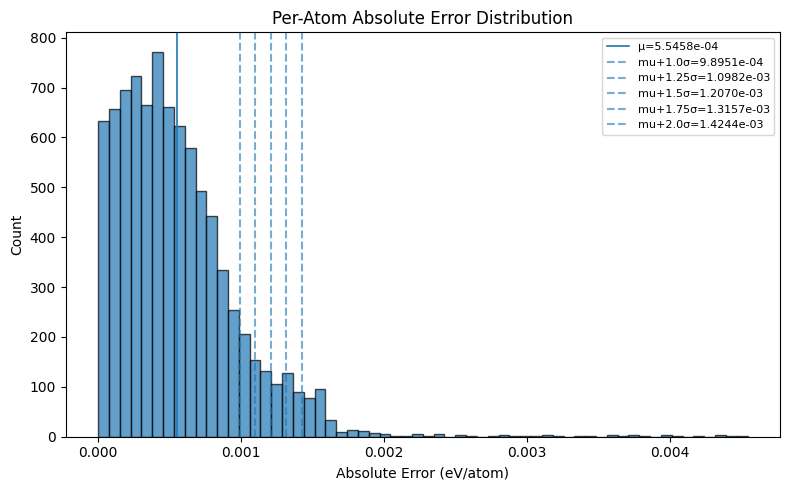

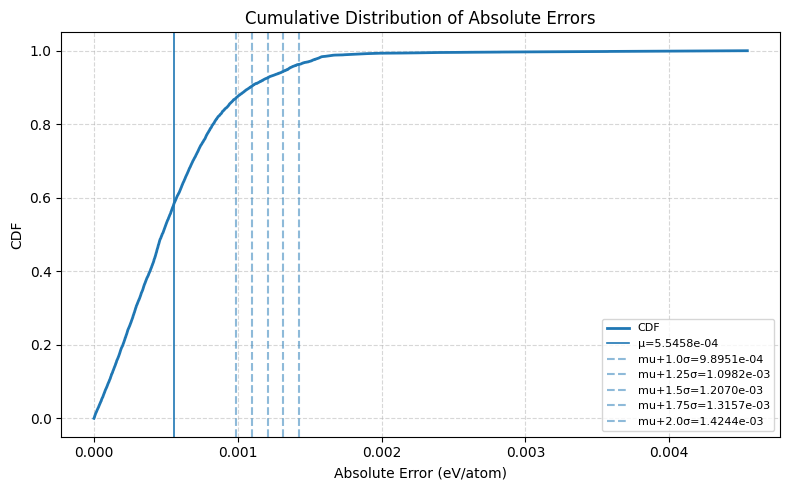

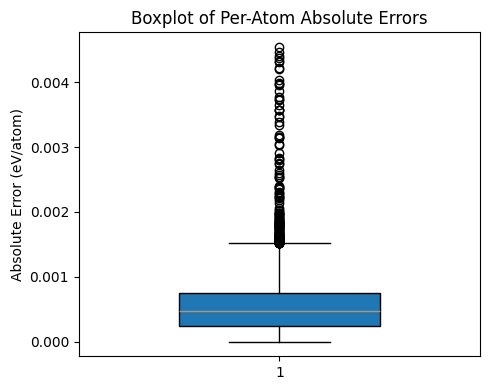


=== OOD Counts ===


,Threshold,Threshold_eV,Count,Fraction_%
0,mu+1.0σ,0.000990,1105,12.768662
1,mu+1.25σ,0.001098,833,9.625607
2,mu+1.5σ,0.001207,643,7.430090
3,mu+1.75σ,0.001316,488,5.639011
4,mu+2.0σ,0.001424,323,3.732378


In [10]:
# === Plot distribution & compute OOD counts for various sigma thresholds ===
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, json
from pathlib import Path

# Configuration
out_dir = MD / "error_analysis"
out_dir.mkdir(exist_ok=True)

# Extract the array of absolute per-atom errors
errs_abs = cmp_k.loc[np.isfinite(cmp_k["per_atom_abs_error_eV"]),
                     "per_atom_abs_error_eV"].to_numpy()

# Basic stats
mu = np.mean(errs_abs)
sigma = np.std(errs_abs, ddof=1)
n = len(errs_abs)

# --- 1️⃣ Compute OOD counts ---
thresholds = {
    "mu+1.0σ": mu + 1.0 * sigma,
    "mu+1.25σ": mu + 1.25 * sigma,
    "mu+1.5σ": mu + 1.5 * sigma,
    "mu+1.75σ": mu + 1.75 * sigma,
    "mu+2.0σ": mu + 2.0 * sigma,
}

ood_stats = {}
for label, thr in thresholds.items():
    count = int(np.sum(errs_abs > thr))
    frac = 100 * count / n
    ood_stats[label] = {"threshold_eV": thr, "count": count, "fraction_%": frac}

# --- 2️⃣ Save OOD info + basic stats ---
summary = {
    "N_valid": n,
    "mu_eV": mu,
    "sigma_eV": sigma,
    "min_eV": float(np.min(errs_abs)),
    "max_eV": float(np.max(errs_abs)),
    "median_eV": float(np.median(errs_abs)),
    "mean+sigma_criteria": ood_stats,
}
json_path = out_dir / "OOD_threshold_summary.json"
with open(json_path, "w") as f:
    json.dump(summary, f, indent=2)
print(f"Saved OOD threshold summary → {json_path}")

# --- 3️⃣ Visualization (fixed legends) ---
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(8,5))
plt.hist(errs_abs, bins=60, edgecolor='black', alpha=0.7)
# plot μ and thresholds WITH labels so legend can discover them
plt.axvline(mu, linestyle='-', linewidth=1.2, label=f"μ={mu:.4e}")
for lbl, thr in thresholds.items():
    plt.axvline(thr, linestyle='--', alpha=0.6, label=f"{lbl}={thr:.4e}")
plt.title("Per-Atom Absolute Error Distribution")
plt.xlabel("Absolute Error (eV/atom)")
plt.ylabel("Count")
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(out_dir / "hist_absolute_error.png", dpi=300)

# Cumulative distribution plot
plt.figure(figsize=(8,5))
sorted_errs = np.sort(errs_abs)
cdf = np.arange(1, n+1) / n
plt.plot(sorted_errs, cdf, linewidth=2, label="CDF")
plt.axvline(mu, linestyle='-', linewidth=1.2, label=f"μ={mu:.4e}")
for lbl, thr in thresholds.items():
    plt.axvline(thr, linestyle='--', alpha=0.5, label=f"{lbl}={thr:.4e}")
plt.title("Cumulative Distribution of Absolute Errors")
plt.xlabel("Absolute Error (eV/atom)")
plt.ylabel("CDF")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(out_dir / "cdf_absolute_error.png", dpi=300)

# Boxplot
plt.figure(figsize=(5,4))
plt.boxplot(errs_abs, vert=True, widths=0.5, patch_artist=True)
plt.ylabel("Absolute Error (eV/atom)")
plt.title("Boxplot of Per-Atom Absolute Errors")
plt.tight_layout()
plt.savefig(out_dir / "boxplot_absolute_error.png", dpi=300)
plt.show()

# --- 4️⃣ Export OOD tables for inspection ---
ood_table = pd.DataFrame([
    {"Threshold": k, "Threshold_eV": v["threshold_eV"],
     "Count": v["count"], "Fraction_%": v["fraction_%"]}
    for k, v in ood_stats.items()
])
ood_table.to_excel(out_dir / "OOD_threshold_table.xlsx", index=False)
ood_table.to_json(out_dir / "OOD_threshold_table.json", orient="records", indent=2)

print("\n=== OOD Counts ===")
display(ood_table)


In [11]:
# ==== Compact final parser that correctly identifies off__ and fractional strains ====
import re, numpy as np, pandas as pd
from pathlib import Path

errs_abs = cmp_k.loc[np.isfinite(cmp_k["per_atom_abs_error_eV"]), "per_atom_abs_error_eV"].to_numpy()
mu = float(np.mean(errs_abs))
sigma = float(np.std(errs_abs, ddof=1))
thr = mu + 2.0 * sigma

def parse_meta_from_key_final(key: str):
    meta = dict(llzo_dir=None, termination=None, order_tag=None, sto_flag=None,
                li_facet=None, temperature_K=None,
                strain_sign=None, strain_percent=None, strain_fraction=None,
                perturbed=False)
    name = key[:-4] if key.lower().endswith(".cif") else key

    # llzo dir + termination/order
    m = re.search(r"LLZO_(\d{3})_", name)
    if m: meta["llzo_dir"] = m.group(1)
    m = re.search(r"LLZO_\d{3}_([A-Za-z]+)_([A-Za-z0-9]+)_", name)
    if m: meta.update(dict(termination=m.group(1), order_tag=m.group(2)))

    # sto/off flag (handles _off__ , _offsto__ , _sto__)
    m = re.search(r"_(sto|offsto|off)__", name)
    if m:
        v = m.group(1)
        meta["sto_flag"] = "offsto" if v.startswith("off") else "sto"
    else:
        meta["sto_flag"] = "offsto"

    # facet + temperature
    m = re.search(r"__Li_(\d{3})_", name)
    if m: meta["li_facet"] = m.group(1)
    m = re.search(r"_T(\d{3})_", name)
    if m: 
        try: meta["temperature_K"] = int(m.group(1))
        except: pass

    # strain (integer or fractional like 0.015)
    m = re.search(r"_strain([+\-])(\d+(?:\.\d+)?)", name)
    if m:
        sign, val = m.groups()
        val = float(val)
        perc = val*100 if val <= 0.2 else val    # 0.015 → 1.5 %
        if sign == "-": perc = -perc
        meta["strain_sign"] = sign
        meta["strain_percent"] = perc
        meta["strain_fraction"] = perc/100
    meta["perturbed"] = "perturbed" in name.lower()
    return meta

def label_dataset_t1_t3_final(row):
    sp = row.get("strain_percent", None)
    if sp is None or not np.isfinite(sp): return "T1"
    asp = abs(float(sp))
    return "T3" if asp in (1.0, 1.5) else "T1"

# rebuild μ+2σ dataframe
ood_df = cmp_k.loc[cmp_k["per_atom_abs_error_eV"] > thr].copy()
ood_df["natoms"] = ood_df["natoms"].astype("Int64")
meta_df = pd.DataFrame([parse_meta_from_key_final(k) for k in ood_df["key"]], index=ood_df.index)
ood_full = pd.concat([ood_df, meta_df], axis=1)
ood_full["dataset_label"] = ood_full.apply(label_dataset_t1_t3_final, axis=1)
ood_full["threshold_mu_plus_2sigma_eV"] = thr

cols = ["file","key","dataset_label","natoms","per_atom_abs_error_eV","threshold_mu_plus_2sigma_eV",
        "llzo_dir","termination","order_tag","sto_flag","li_facet","temperature_K",
        "strain_sign","strain_percent","strain_fraction","perturbed",
        "MACE_ensemble_mean_energy_eV","CHGNet_energy_eV"]
ood_export = ood_full[cols].sort_values(["dataset_label","per_atom_abs_error_eV"], ascending=[True,False])

xlsx_path = out_dir / "OOD_mu_plus_2sigma_list.xlsx"
json_path = out_dir / "OOD_mu_plus_2sigma_list.json"
ood_export.to_excel(xlsx_path, index=False)
ood_export.to_json(json_path, orient="records", indent=2)

print("μ+2σ OOD list rebuilt successfully.")
print("sto_flag unique:", ood_export["sto_flag"].unique())
print("strain_percent unique:", sorted(ood_export["strain_percent"].dropna().unique()))
print(ood_export["dataset_label"].value_counts(dropna=False))


μ+2σ OOD list rebuilt successfully.
sto_flag unique: ['sto' 'offsto']
strain_percent unique: [-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
dataset_label
T3    163
T1    160
Name: count, dtype: int64


In [12]:
# ==== Compact final parser that correctly identifies off__ and fractional strains ====
import re, numpy as np, pandas as pd
from pathlib import Path

errs_abs = cmp_k.loc[np.isfinite(cmp_k["per_atom_abs_error_eV"]), "per_atom_abs_error_eV"].to_numpy()
mu = float(np.mean(errs_abs))
sigma = float(np.std(errs_abs, ddof=1))
thr = mu + 1.0 * sigma

def parse_meta_from_key_final(key: str):
    meta = dict(llzo_dir=None, termination=None, order_tag=None, sto_flag=None,
                li_facet=None, temperature_K=None,
                strain_sign=None, strain_percent=None, strain_fraction=None,
                perturbed=False)
    name = key[:-4] if key.lower().endswith(".cif") else key

    # llzo dir + termination/order
    m = re.search(r"LLZO_(\d{3})_", name)
    if m: meta["llzo_dir"] = m.group(1)
    m = re.search(r"LLZO_\d{3}_([A-Za-z]+)_([A-Za-z0-9]+)_", name)
    if m: meta.update(dict(termination=m.group(1), order_tag=m.group(2)))

    # sto/off flag (handles _off__ , _offsto__ , _sto__)
    m = re.search(r"_(sto|offsto|off)__", name)
    if m:
        v = m.group(1)
        meta["sto_flag"] = "offsto" if v.startswith("off") else "sto"
    else:
        meta["sto_flag"] = "offsto"

    # facet + temperature
    m = re.search(r"__Li_(\d{3})_", name)
    if m: meta["li_facet"] = m.group(1)
    m = re.search(r"_T(\d{3})_", name)
    if m: 
        try: meta["temperature_K"] = int(m.group(1))
        except: pass

    # strain (integer or fractional like 0.015)
    m = re.search(r"_strain([+\-])(\d+(?:\.\d+)?)", name)
    if m:
        sign, val = m.groups()
        val = float(val)
        perc = val*100 if val <= 0.2 else val    # 0.015 → 1.5 %
        if sign == "-": perc = -perc
        meta["strain_sign"] = sign
        meta["strain_percent"] = perc
        meta["strain_fraction"] = perc/100
    meta["perturbed"] = "perturbed" in name.lower()
    return meta

def label_dataset_t1_t3_final(row):
    sp = row.get("strain_percent", None)
    if sp is None or not np.isfinite(sp): return "T1"
    asp = abs(float(sp))
    return "T3" if asp in (1.0, 1.5) else "T1"

# rebuild μ+2σ dataframe
ood_df = cmp_k.loc[cmp_k["per_atom_abs_error_eV"] > thr].copy()
ood_df["natoms"] = ood_df["natoms"].astype("Int64")
meta_df = pd.DataFrame([parse_meta_from_key_final(k) for k in ood_df["key"]], index=ood_df.index)
ood_full = pd.concat([ood_df, meta_df], axis=1)
ood_full["dataset_label"] = ood_full.apply(label_dataset_t1_t3_final, axis=1)
ood_full["threshold_mu_plus_1sigma_eV"] = thr

cols = ["file","key","dataset_label","natoms","per_atom_abs_error_eV","threshold_mu_plus_1sigma_eV",
        "llzo_dir","termination","order_tag","sto_flag","li_facet","temperature_K",
        "strain_sign","strain_percent","strain_fraction","perturbed",
        "MACE_ensemble_mean_energy_eV","CHGNet_energy_eV"]
ood_export = ood_full[cols].sort_values(["dataset_label","per_atom_abs_error_eV"], ascending=[True,False])

xlsx_path = out_dir / "OOD_mu_plus_1sigma_list.xlsx"
json_path = out_dir / "OOD_mu_plus_1sigma_list.json"
ood_export.to_excel(xlsx_path, index=False)
ood_export.to_json(json_path, orient="records", indent=2)

print("μ+1σ OOD list rebuilt successfully.")
print("sto_flag unique:", ood_export["sto_flag"].unique())
print("strain_percent unique:", sorted(ood_export["strain_percent"].dropna().unique()))
print(ood_export["dataset_label"].value_counts(dropna=False))


μ+1σ OOD list rebuilt successfully.
sto_flag unique: ['sto' 'offsto']
strain_percent unique: [-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
dataset_label
T1    565
T3    540
Name: count, dtype: int64


In [13]:
# ==== Compact final parser that correctly identifies off__ and fractional strains ====
import re, numpy as np, pandas as pd
from pathlib import Path

errs_abs = cmp_k.loc[np.isfinite(cmp_k["per_atom_abs_error_eV"]), "per_atom_abs_error_eV"].to_numpy()
mu = float(np.mean(errs_abs))
sigma = float(np.std(errs_abs, ddof=1))
thr = mu + 1.25 * sigma

def parse_meta_from_key_final(key: str):
    meta = dict(llzo_dir=None, termination=None, order_tag=None, sto_flag=None,
                li_facet=None, temperature_K=None,
                strain_sign=None, strain_percent=None, strain_fraction=None,
                perturbed=False)
    name = key[:-4] if key.lower().endswith(".cif") else key

    # llzo dir + termination/order
    m = re.search(r"LLZO_(\d{3})_", name)
    if m: meta["llzo_dir"] = m.group(1)
    m = re.search(r"LLZO_\d{3}_([A-Za-z]+)_([A-Za-z0-9]+)_", name)
    if m: meta.update(dict(termination=m.group(1), order_tag=m.group(2)))

    # sto/off flag (handles _off__ , _offsto__ , _sto__)
    m = re.search(r"_(sto|offsto|off)__", name)
    if m:
        v = m.group(1)
        meta["sto_flag"] = "offsto" if v.startswith("off") else "sto"
    else:
        meta["sto_flag"] = "offsto"

    # facet + temperature
    m = re.search(r"__Li_(\d{3})_", name)
    if m: meta["li_facet"] = m.group(1)
    m = re.search(r"_T(\d{3})_", name)
    if m: 
        try: meta["temperature_K"] = int(m.group(1))
        except: pass

    # strain (integer or fractional like 0.015)
    m = re.search(r"_strain([+\-])(\d+(?:\.\d+)?)", name)
    if m:
        sign, val = m.groups()
        val = float(val)
        perc = val*100 if val <= 0.2 else val    # 0.015 → 1.5 %
        if sign == "-": perc = -perc
        meta["strain_sign"] = sign
        meta["strain_percent"] = perc
        meta["strain_fraction"] = perc/100
    meta["perturbed"] = "perturbed" in name.lower()
    return meta

def label_dataset_t1_t3_final(row):
    sp = row.get("strain_percent", None)
    if sp is None or not np.isfinite(sp): return "T1"
    asp = abs(float(sp))
    return "T3" if asp in (1.0, 1.5) else "T1"

# rebuild μ+2σ dataframe
ood_df = cmp_k.loc[cmp_k["per_atom_abs_error_eV"] > thr].copy()
ood_df["natoms"] = ood_df["natoms"].astype("Int64")
meta_df = pd.DataFrame([parse_meta_from_key_final(k) for k in ood_df["key"]], index=ood_df.index)
ood_full = pd.concat([ood_df, meta_df], axis=1)
ood_full["dataset_label"] = ood_full.apply(label_dataset_t1_t3_final, axis=1)
ood_full["threshold_mu_plus_125sigma_eV"] = thr

cols = ["file","key","dataset_label","natoms","per_atom_abs_error_eV","threshold_mu_plus_125sigma_eV",
        "llzo_dir","termination","order_tag","sto_flag","li_facet","temperature_K",
        "strain_sign","strain_percent","strain_fraction","perturbed",
        "MACE_ensemble_mean_energy_eV","CHGNet_energy_eV"]
ood_export = ood_full[cols].sort_values(["dataset_label","per_atom_abs_error_eV"], ascending=[True,False])

xlsx_path = out_dir / "OOD_mu_plus_125sigma_list.xlsx"
json_path = out_dir / "OOD_mu_plus_125sigma_list.json"
ood_export.to_excel(xlsx_path, index=False)
ood_export.to_json(json_path, orient="records", indent=2)

print("μ+1.25σ OOD list rebuilt successfully.")
print("sto_flag unique:", ood_export["sto_flag"].unique())
print("strain_percent unique:", sorted(ood_export["strain_percent"].dropna().unique()))
print(ood_export["dataset_label"].value_counts(dropna=False))


μ+1.25σ OOD list rebuilt successfully.
sto_flag unique: ['sto' 'offsto']
strain_percent unique: [-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
dataset_label
T3    432
T1    401
Name: count, dtype: int64


In [14]:
# ==== Compact final parser that correctly identifies off__ and fractional strains ====
import re, numpy as np, pandas as pd
from pathlib import Path

errs_abs = cmp_k.loc[np.isfinite(cmp_k["per_atom_abs_error_eV"]), "per_atom_abs_error_eV"].to_numpy()
mu = float(np.mean(errs_abs))
sigma = float(np.std(errs_abs, ddof=1))
thr = mu + 1.5 * sigma

def parse_meta_from_key_final(key: str):
    meta = dict(llzo_dir=None, termination=None, order_tag=None, sto_flag=None,
                li_facet=None, temperature_K=None,
                strain_sign=None, strain_percent=None, strain_fraction=None,
                perturbed=False)
    name = key[:-4] if key.lower().endswith(".cif") else key

    # llzo dir + termination/order
    m = re.search(r"LLZO_(\d{3})_", name)
    if m: meta["llzo_dir"] = m.group(1)
    m = re.search(r"LLZO_\d{3}_([A-Za-z]+)_([A-Za-z0-9]+)_", name)
    if m: meta.update(dict(termination=m.group(1), order_tag=m.group(2)))

    # sto/off flag (handles _off__ , _offsto__ , _sto__)
    m = re.search(r"_(sto|offsto|off)__", name)
    if m:
        v = m.group(1)
        meta["sto_flag"] = "offsto" if v.startswith("off") else "sto"
    else:
        meta["sto_flag"] = "offsto"

    # facet + temperature
    m = re.search(r"__Li_(\d{3})_", name)
    if m: meta["li_facet"] = m.group(1)
    m = re.search(r"_T(\d{3})_", name)
    if m: 
        try: meta["temperature_K"] = int(m.group(1))
        except: pass

    # strain (integer or fractional like 0.015)
    m = re.search(r"_strain([+\-])(\d+(?:\.\d+)?)", name)
    if m:
        sign, val = m.groups()
        val = float(val)
        perc = val*100 if val <= 0.2 else val    # 0.015 → 1.5 %
        if sign == "-": perc = -perc
        meta["strain_sign"] = sign
        meta["strain_percent"] = perc
        meta["strain_fraction"] = perc/100
    meta["perturbed"] = "perturbed" in name.lower()
    return meta

def label_dataset_t1_t3_final(row):
    sp = row.get("strain_percent", None)
    if sp is None or not np.isfinite(sp): return "T1"
    asp = abs(float(sp))
    return "T3" if asp in (1.0, 1.5) else "T1"

# rebuild μ+2σ dataframe
ood_df = cmp_k.loc[cmp_k["per_atom_abs_error_eV"] > thr].copy()
ood_df["natoms"] = ood_df["natoms"].astype("Int64")
meta_df = pd.DataFrame([parse_meta_from_key_final(k) for k in ood_df["key"]], index=ood_df.index)
ood_full = pd.concat([ood_df, meta_df], axis=1)
ood_full["dataset_label"] = ood_full.apply(label_dataset_t1_t3_final, axis=1)
ood_full["threshold_mu_plus_150sigma_eV"] = thr

cols = ["file","key","dataset_label","natoms","per_atom_abs_error_eV","threshold_mu_plus_150sigma_eV",
        "llzo_dir","termination","order_tag","sto_flag","li_facet","temperature_K",
        "strain_sign","strain_percent","strain_fraction","perturbed",
        "MACE_ensemble_mean_energy_eV","CHGNet_energy_eV"]
ood_export = ood_full[cols].sort_values(["dataset_label","per_atom_abs_error_eV"], ascending=[True,False])

xlsx_path = out_dir / "OOD_mu_plus_150sigma_list.xlsx"
json_path = out_dir / "OOD_mu_plus_150sigma_list.json"
ood_export.to_excel(xlsx_path, index=False)
ood_export.to_json(json_path, orient="records", indent=2)

print("μ+1.5σ OOD list rebuilt successfully.")
print("sto_flag unique:", ood_export["sto_flag"].unique())
print("strain_percent unique:", sorted(ood_export["strain_percent"].dropna().unique()))
print(ood_export["dataset_label"].value_counts(dropna=False))


μ+1.5σ OOD list rebuilt successfully.
sto_flag unique: ['sto' 'offsto']
strain_percent unique: [-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
dataset_label
T3    350
T1    293
Name: count, dtype: int64


In [15]:
# ==== Compact final parser that correctly identifies off__ and fractional strains ====
import re, numpy as np, pandas as pd
from pathlib import Path

errs_abs = cmp_k.loc[np.isfinite(cmp_k["per_atom_abs_error_eV"]), "per_atom_abs_error_eV"].to_numpy()
mu = float(np.mean(errs_abs))
sigma = float(np.std(errs_abs, ddof=1))
thr = mu + 1.75 * sigma

def parse_meta_from_key_final(key: str):
    meta = dict(llzo_dir=None, termination=None, order_tag=None, sto_flag=None,
                li_facet=None, temperature_K=None,
                strain_sign=None, strain_percent=None, strain_fraction=None,
                perturbed=False)
    name = key[:-4] if key.lower().endswith(".cif") else key

    # llzo dir + termination/order
    m = re.search(r"LLZO_(\d{3})_", name)
    if m: meta["llzo_dir"] = m.group(1)
    m = re.search(r"LLZO_\d{3}_([A-Za-z]+)_([A-Za-z0-9]+)_", name)
    if m: meta.update(dict(termination=m.group(1), order_tag=m.group(2)))

    # sto/off flag (handles _off__ , _offsto__ , _sto__)
    m = re.search(r"_(sto|offsto|off)__", name)
    if m:
        v = m.group(1)
        meta["sto_flag"] = "offsto" if v.startswith("off") else "sto"
    else:
        meta["sto_flag"] = "offsto"

    # facet + temperature
    m = re.search(r"__Li_(\d{3})_", name)
    if m: meta["li_facet"] = m.group(1)
    m = re.search(r"_T(\d{3})_", name)
    if m: 
        try: meta["temperature_K"] = int(m.group(1))
        except: pass

    # strain (integer or fractional like 0.015)
    m = re.search(r"_strain([+\-])(\d+(?:\.\d+)?)", name)
    if m:
        sign, val = m.groups()
        val = float(val)
        perc = val*100 if val <= 0.2 else val    # 0.015 → 1.5 %
        if sign == "-": perc = -perc
        meta["strain_sign"] = sign
        meta["strain_percent"] = perc
        meta["strain_fraction"] = perc/100
    meta["perturbed"] = "perturbed" in name.lower()
    return meta

def label_dataset_t1_t3_final(row):
    sp = row.get("strain_percent", None)
    if sp is None or not np.isfinite(sp): return "T1"
    asp = abs(float(sp))
    return "T3" if asp in (1.0, 1.5) else "T1"

# rebuild μ+2σ dataframe
ood_df = cmp_k.loc[cmp_k["per_atom_abs_error_eV"] > thr].copy()
ood_df["natoms"] = ood_df["natoms"].astype("Int64")
meta_df = pd.DataFrame([parse_meta_from_key_final(k) for k in ood_df["key"]], index=ood_df.index)
ood_full = pd.concat([ood_df, meta_df], axis=1)
ood_full["dataset_label"] = ood_full.apply(label_dataset_t1_t3_final, axis=1)
ood_full["threshold_mu_plus_175sigma_eV"] = thr

cols = ["file","key","dataset_label","natoms","per_atom_abs_error_eV","threshold_mu_plus_175sigma_eV",
        "llzo_dir","termination","order_tag","sto_flag","li_facet","temperature_K",
        "strain_sign","strain_percent","strain_fraction","perturbed",
        "MACE_ensemble_mean_energy_eV","CHGNet_energy_eV"]
ood_export = ood_full[cols].sort_values(["dataset_label","per_atom_abs_error_eV"], ascending=[True,False])

xlsx_path = out_dir / "OOD_mu_plus_175sigma_list.xlsx"
json_path = out_dir / "OOD_mu_plus_175sigma_list.json"
ood_export.to_excel(xlsx_path, index=False)
ood_export.to_json(json_path, orient="records", indent=2)

print("μ+1.75σ OOD list rebuilt successfully.")
print("sto_flag unique:", ood_export["sto_flag"].unique())
print("strain_percent unique:", sorted(ood_export["strain_percent"].dropna().unique()))
print(ood_export["dataset_label"].value_counts(dropna=False))


μ+1.75σ OOD list rebuilt successfully.
sto_flag unique: ['sto' 'offsto']
strain_percent unique: [-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
dataset_label
T3    267
T1    221
Name: count, dtype: int64


In [16]:
# --- Threshold sweep: summary stats of |ΔE| per atom ---
import numpy as np, pandas as pd, re

df0 = cmp_k.copy()
df0 = df0[np.isfinite(df0['per_atom_abs_error_eV'])].copy()
errs = df0['per_atom_abs_error_eV'].to_numpy()
N = len(df0)

mu = float(np.mean(errs))
sigma = float(np.std(errs, ddof=1))

# define thresholds
tau_map = {
    "mu+1.0σ": mu + 1.0*sigma,
    "mu+1.25σ": mu + 1.25*sigma,
    "mu+1.5σ": mu + 1.5*sigma,
    "mu+1.75σ": mu + 1.75*sigma,
    "mu+2.0σ": mu + 2.0*sigma,
}

rows = []
for name, tau in tau_map.items():
    mask = df0['per_atom_abs_error_eV'] > tau
    s = df0.loc[mask, 'per_atom_abs_error_eV']
    rows.append({
        "threshold": name,
        "tau_eV": tau,
        "count": int(mask.sum()),
        "fraction_%": 100.0*mask.mean(),
        "mean_abs_eV": float(s.mean()) if len(s) else np.nan,
        "median_abs_eV": float(s.median()) if len(s) else np.nan,
        "p90_abs_eV": float(s.quantile(0.90)) if len(s) else np.nan,
        "p95_abs_eV": float(s.quantile(0.95)) if len(s) else np.nan,
        "max_abs_eV": float(s.max()) if len(s) else np.nan,
    })

thr_stats = pd.DataFrame(rows).sort_values("tau_eV")
print("=== Per-threshold |ΔE| summary ===")
print(thr_stats.to_string(index=False, float_format=lambda x: f"{x:.6e}"))


=== Per-threshold |ΔE| summary ===
threshold       tau_eV  count   fraction_%  mean_abs_eV  median_abs_eV   p90_abs_eV   p95_abs_eV   max_abs_eV
  mu+1.0σ 9.895069e-04   1105 1.276866e+01 1.378460e-03   1.270077e-03 1.656294e-03 2.121002e-03 4.543105e-03
 mu+1.25σ 1.098239e-03    833 9.625607e+00 1.488196e-03   1.357145e-03 1.806005e-03 2.450969e-03 4.543105e-03
  mu+1.5σ 1.206971e-03    643 7.430090e+00 1.588369e-03   1.426304e-03 1.944339e-03 2.819927e-03 4.543105e-03
 mu+1.75σ 1.315703e-03    488 5.639011e+00 1.692667e-03   1.507456e-03 2.278029e-03 3.177830e-03 4.543105e-03
  mu+2.0σ 1.424435e-03    323 3.732378e+00 1.859706e-03   1.570504e-03 2.818519e-03 3.635683e-03 4.543105e-03
